In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import Utils.graphing_helpers
import importlib
importlib.reload(Utils.graphing_helpers)
from Utils.graphing_helpers import (plot_vicsek_phase_diagram, plot_dir_cross_vel_phase_diagram,  plot_dir_cross_vel_norm_phase_diagram, 
                                    save_fig_pdf, edges_from_centers_log, edges_from_centers_linear)
from Analysis_Calculations.local_packing_fraction import (get_local_packing_fraction, get_packing_mean_and_std_dev)
import read_data as rd

In [23]:
phi = 0.6
v0 = 0.03
Dr_vals = np.logspace(-4,-1,num=13)
Jv_vals = [0, *np.logspace(-4,-1,num=13)]
J_vals = [0, *(np.logspace(-4,-1,num=13)/v0)]

In [24]:
def load_statistic_data(value_key, Dr_vals, J_vals, exp_dir):
    statistic_values = []
    for D_r in Dr_vals:
        row_of_values = []
        for J in J_vals:
            single_simulation_stats_filename = os.path.join(exp_dir, "J=%.4f_and_Dr=%.4f"%(J, D_r), 'single_stats.json')
            with open(single_simulation_stats_filename) as stats_file:
                stats = json.loads(stats_file.read())
            row_of_values.append(stats[value_key])
        statistic_values.append(row_of_values)
    statistic_values = np.array(statistic_values)
    return statistic_values

In [25]:
save_dir = "/home/ryanlopez/Velocity_Align_MIPS_Transition"
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)

In [26]:
simulation_desc = r"$\phi=%.2f$, $v_0=%.1e$, k=1, L=70, Simulation Time = $5 \times 10^{5}$"%(phi, v0)
plt_xlabel = r'$Jv_0$'
plt_ylabel = r'$D_r$'

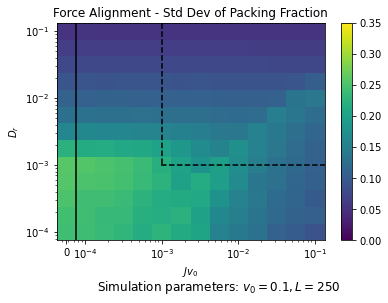

In [46]:
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
packing_std_dev_vals = load_statistic_data('packing_std_dev', Dr_vals, J_vals, exp_dir)
save_filename = None #os.path.join(save_dir, 'vicsek_2.pdf')

def extend_log_scale_back(values):
    log_values = np.log(values)
    diff_between_log_values = np.mean(np.diff(log_values))
    log_value_to_add = log_values[0]-diff_between_log_values
    value_to_add = np.exp(log_value_to_add)
    extended_values = [value_to_add, *values]
    return extended_values

def plot_phase_diagram_with_zero(x_values, y_values, plot_values, plt_xlabel = None, plt_ylabel = None, vmin=0, vmax=1, save_filename=None):
    if x_values[0] != 0 or y_values[0] == 0:
        raise ValueError('X axis should have zero value')
    fig, ax = plt.subplots()
    extended_x_bins = extend_log_scale_back(x_values[1:])
    x_bins = edges_from_centers_log(extended_x_bins)
    y_bins = edges_from_centers_log(y_values)
    plt.xscale('log')
    plt.yscale('log')
    xedges, yedges = np.meshgrid(x_bins,y_bins)
    plot = ax.pcolormesh(xedges, yedges, plot_values, vmin=vmin, vmax=vmax)#, edgecolors='k')
    plt.colorbar(plot)
    plt.title('Force Alignment - Std Dev of Packing Fraction')
    plt.xlabel(plt_xlabel)
    plt.ylabel(plt_ylabel)
    plt.axvline(x=x_bins[1], color='black')
    plt.axvline(x=1e-3, ymin = 0.35, color='black', linestyle='--')
    plt.axhline(y=1e-3, xmin = 0.39, color='black', linestyle='--')
    plt.xticks([extended_x_bins[0], x_values[1], x_values[5], x_values[9], x_values[13]], ['0', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$'])
    fig.text(.5, -0.05, r'Simulation parameters: $v_0=0.1, L=250$', ha='center', fontsize=12)
    #fig.text(.5, -0.13, caption_line_2, ha='center', fontsize=12)
    if save_filename != None:
        save_fig_pdf(save_filename)

plot_phase_diagram_with_zero(Jv_vals, Dr_vals, packing_std_dev_vals, plt_xlabel=plt_xlabel, plt_ylabel=plt_ylabel, vmax=0.35)

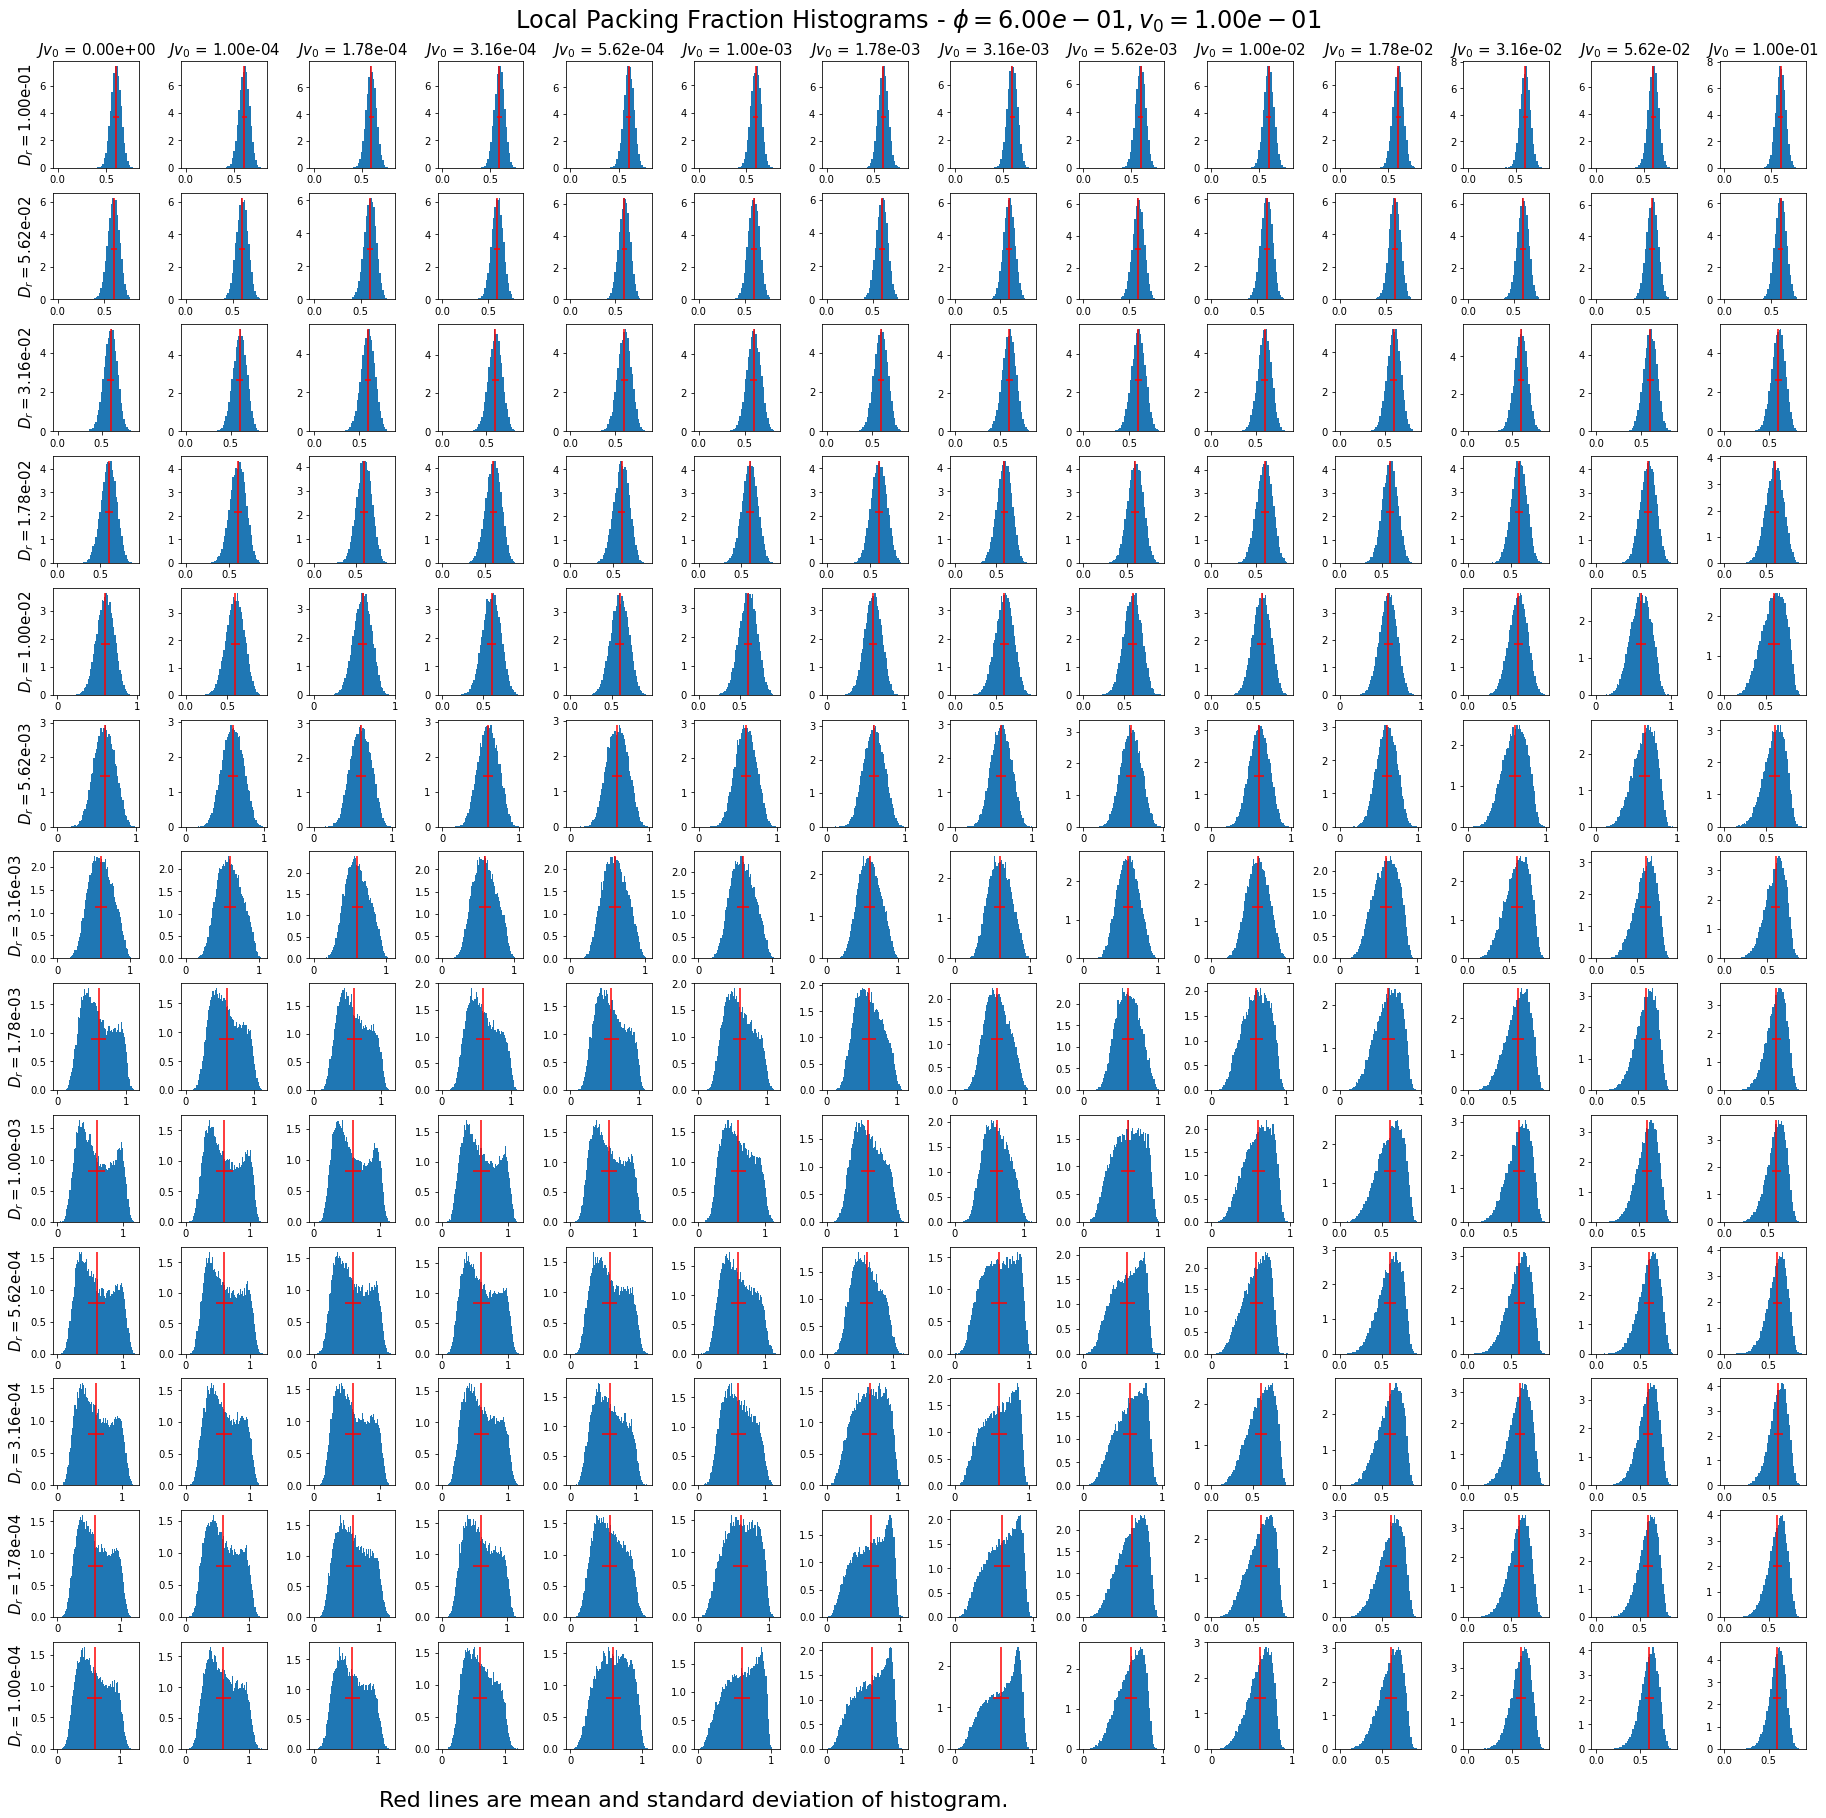

In [47]:
#Plot For Single Group of Simulations
box_length = 70
num_bins_along_dim = int(box_length/14)
particle_area = np.pi

fig, axs = plt.subplots(13,14, figsize = (25, 25))
fig.tight_layout(pad=0.5)
fig.suptitle(rf'Local Packing Fraction Histograms - $\phi={phi:.2e}, v_0={v0:.2e}$', fontsize = 24)

for J_index, Jv in enumerate(Jv_vals):
    for Dr_index, Dr in enumerate(Dr_vals):
        J = Jv/v0
        #Load data
        run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
        analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
        with open(os.path.join(analysis_data_dir, 'local_packing_hist.npy'), 'rb') as local_packing_file:
            local_packing_fraction = np.load(local_packing_file)
        mean, std_dev, bin_centers = get_packing_mean_and_std_dev(local_packing_fraction, num_bins_along_dim, box_length, particle_area)
        bin_edges = edges_from_centers_linear(bin_centers)
        y, _, _ = axs[-Dr_index-1, J_index].hist(local_packing_fraction.flatten(), bins=bin_edges, density=True)
        axs[-Dr_index-1, J_index].vlines(mean, ymin=0, ymax=y.max(), color='red')
        axs[-Dr_index-1, J_index].hlines(y=y.max()/2, xmin=mean-std_dev/2, xmax=mean+std_dev/2, colors='r')
        if J_index == 0:
            axs[-Dr_index-1, J_index].set_ylabel(r'$D_r = $' + f'{Dr:.2e}', fontsize = 15)
        if Dr_index == len(Dr_vals)-1:
            axs[-Dr_index-1, J_index].set_title(fr"$Jv_0$ = {Jv:.2e}", fontsize = 15)
plt.subplots_adjust(top=0.95)
plt.text(0.2, -0.02, r'Red lines are mean and standard deviation of histogram.', fontsize=22, transform=plt.gcf().transFigure)
pdf_filename = 'force_alignment_hists.pdf'
save_fig_pdf(pdf_filename)

In [48]:
np.arange(900, 1000)

array([900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912,
       913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925,
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990,
       991, 992, 993, 994, 995, 996, 997, 998, 999])

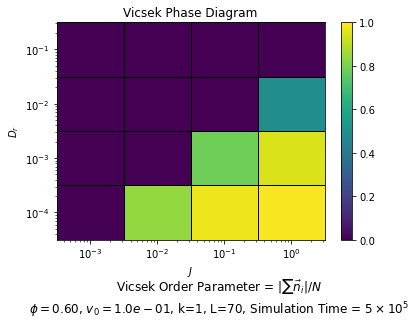

In [18]:
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
vicsek_vals = load_statistic_data('vicsek_param', Dr_vals, J_vals, exp_dir)
save_filename = None #os.path.join(save_dir, 'vicsek_2.pdf')
plot_vicsek_phase_diagram(J_vals, Dr_vals, vicsek_vals, plt_xlabel=plt_xlabel, plt_ylabel=plt_ylabel, simulation_desc=simulation_desc,
                            save_filename = save_filename)

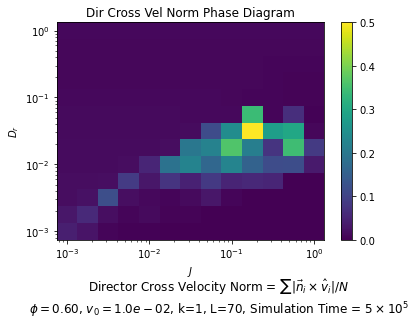

In [49]:
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
dir_cross_vel_norm_vals = load_statistic_data('dir_cross_vel_norm', Dr_vals, J_vals, exp_dir)
save_filename = os.path.join(save_dir, 'dir_cross_vel_norm_2.pdf')
plot_dir_cross_vel_norm_phase_diagram(J_vals, Dr_vals, dir_cross_vel_norm_vals, vmin=0, vmax=0.5, plt_xlabel=plt_xlabel, 
                                        plt_ylabel=plt_ylabel, simulation_desc=simulation_desc, save_filename=save_filename)

In [30]:
np.unravel_index(np.argmax(dir_cross_vel_norm_vals), (13,13))

(7, 9)

In [33]:
Dr_vals[7]

0.05623413251903491

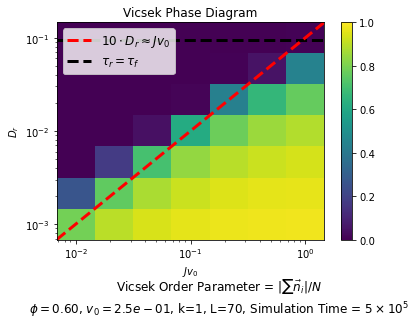

In [29]:
v0 = 0.25
J_vals = Jv_vals / v0
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
vicsek_vals = load_statistic_data('vicsek_param', Dr_vals, J_vals, exp_dir)
simulation_desc = r"$\phi=%.2f$, $v_0=%.1e$, k=1, L=70, Simulation Time = $5 \times 10^{5}$"%(phi, v0)
plot_vicsek_phase_diagram(Jv_vals, Dr_vals, vicsek_vals, plt_xlabel=plt_xlabel, plt_ylabel=plt_ylabel, simulation_desc=simulation_desc)
plot = plt.gcf()
xlim = np.array(plt.xlim())
plt.plot(xlim, xlim/10, c='red', label=r'$10 \cdot D_r \approx Jv_0$', linestyle='--', lw=3)
plt.hlines(0.38*v0, label=r'$\tau_r = \tau_f$', xmin=xlim[0], xmax=xlim[1], color='black', linestyles='--', lw=3)
plt.legend(fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_vicsek.pdf"%(phi, v0))
plt.show()

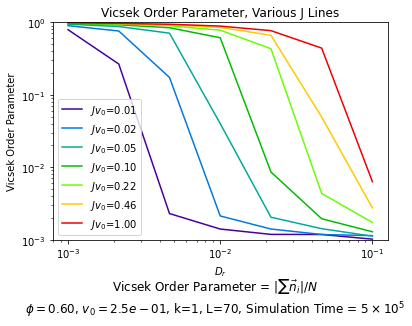

In [47]:
fig, ax = plt.subplots()
colors=plt.cm.nipy_spectral(np.linspace(0,1,len(J_vals)+2))
for J_index, J_val in enumerate(J_vals):
    ax.plot(Dr_vals, vicsek_vals[:, J_index],c=colors[J_index+1], label=r'$Jv_0$=%.2f'%(J_val*v0))
    
ax.set_ylim(0,1)
plt.title(r'Vicsek Order Parameter, Various J Lines')
plt.xlabel(r'$D_r$')
plt.ylabel('Vicsek Order Parameter')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_J_lines.pdf"%(phi, v0))
plt.show()

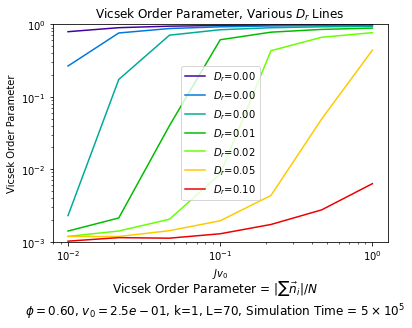

In [51]:
fig, ax = plt.subplots()
colors=plt.cm.nipy_spectral(np.linspace(0,1,len(Dr_vals)+2))
for Dr_index, Dr_val in enumerate(Dr_vals):
    ax.plot(Jv_vals, vicsek_vals[Dr_index],c=colors[Dr_index+1], label=r'$D_r$=%.2f'%(Dr_val))
    
ax.set_ylim(0,1)
plt.title(r'Vicsek Order Parameter, Various $D_r$ Lines')
plt.xlabel(r'$Jv_0$')
plt.ylabel('Vicsek Order Parameter')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_Dr_lines.pdf"%(phi, v0))
plt.show()

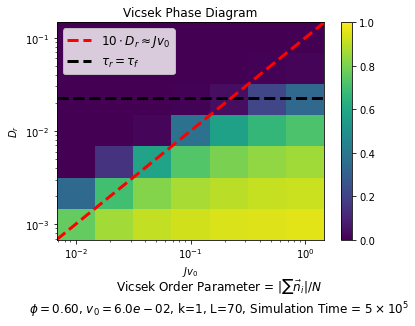

In [52]:
v0 = 0.06
J_vals = Jv_vals / v0
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
vicsek_vals = load_statistic_data('vicsek_param', Dr_vals, J_vals, exp_dir)
simulation_desc = r"$\phi=%.2f$, $v_0=%.1e$, k=1, L=70, Simulation Time = $5 \times 10^{5}$"%(phi, v0)
plot_vicsek_phase_diagram(Jv_vals, Dr_vals, vicsek_vals, plt_xlabel=plt_xlabel, plt_ylabel=plt_ylabel, simulation_desc=simulation_desc)
plot = plt.gcf()
xlim = np.array(plt.xlim())
plt.plot(xlim, xlim/10, c='red', label=r'$10 \cdot D_r \approx Jv_0$', linestyle='--', lw=3)
plt.hlines(0.38*v0, label=r'$\tau_r = \tau_f$', xmin=xlim[0], xmax=xlim[1], color='black', linestyles='--', lw=3)
plt.legend(fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_vicsek.pdf"%(phi, v0))
plt.show()

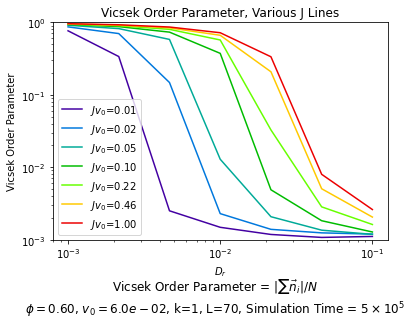

In [53]:
fig, ax = plt.subplots()
colors=plt.cm.nipy_spectral(np.linspace(0,1,len(J_vals)+2))
for J_index, J_val in enumerate(J_vals):
    ax.plot(Dr_vals, vicsek_vals[:, J_index],c=colors[J_index+1], label=r'$Jv_0$=%.2f'%(J_val*v0))
    
ax.set_ylim(0,1)
plt.title(r'Vicsek Order Parameter, Various J Lines')
plt.xlabel(r'$D_r$')
plt.ylabel('Vicsek Order Parameter')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_J_lines.pdf"%(phi, v0))
plt.show()

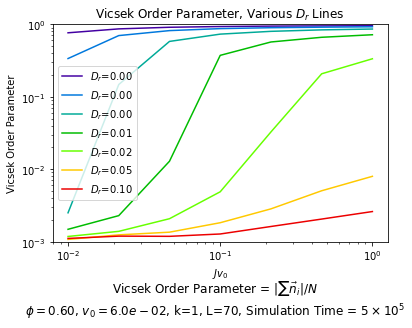

In [54]:
fig, ax = plt.subplots()
colors=plt.cm.nipy_spectral(np.linspace(0,1,len(Dr_vals)+2))
for Dr_index, Dr_val in enumerate(Dr_vals):
    ax.plot(Jv_vals, vicsek_vals[Dr_index],c=colors[Dr_index+1], label=r'$D_r$=%.2f'%(Dr_val))
    
ax.set_ylim(0,1)
plt.title(r'Vicsek Order Parameter, Various $D_r$ Lines')
plt.xlabel(r'$Jv_0$')
plt.ylabel('Vicsek Order Parameter')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_Dr_lines.pdf"%(phi, v0))
plt.show()

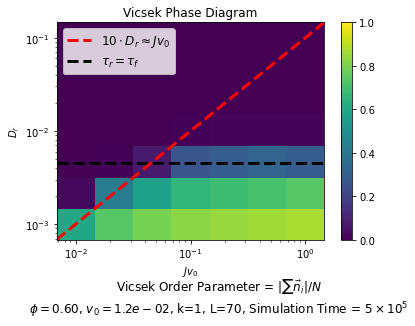

In [55]:
v0 = 0.012
J_vals = Jv_vals / v0
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0) #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)
vicsek_vals = load_statistic_data('vicsek_param', Dr_vals, J_vals, exp_dir)
simulation_desc = r"$\phi=%.2f$, $v_0=%.1e$, k=1, L=70, Simulation Time = $5 \times 10^{5}$"%(phi, v0)
plot_vicsek_phase_diagram(Jv_vals, Dr_vals, vicsek_vals, plt_xlabel=plt_xlabel, plt_ylabel=plt_ylabel, simulation_desc=simulation_desc)
plot = plt.gcf()
xlim = np.array(plt.xlim())
plt.plot(xlim, xlim/10, c='red', label=r'$10 \cdot D_r \approx Jv_0$', linestyle='--', lw=3)
plt.hlines(0.38*v0, label=r'$\tau_r = \tau_f$', xmin=xlim[0], xmax=xlim[1], color='black', linestyles='--', lw=3)
plt.legend(fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_vicsek.pdf"%(phi, v0))
plt.show()

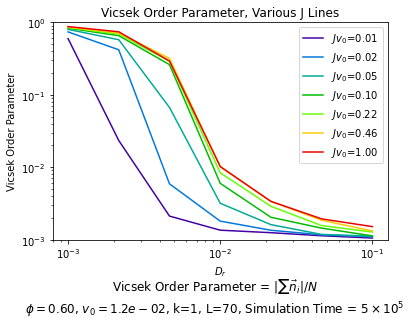

In [56]:
fig, ax = plt.subplots()
colors=plt.cm.nipy_spectral(np.linspace(0,1,len(J_vals)+2))
for J_index, J_val in enumerate(J_vals):
    ax.plot(Dr_vals, vicsek_vals[:, J_index],c=colors[J_index+1], label=r'$Jv_0$=%.2f'%(J_val*v0))
    
ax.set_ylim(0,1)
plt.title(r'Vicsek Order Parameter, Various J Lines')
plt.xlabel(r'$D_r$')
plt.ylabel('Vicsek Order Parameter')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_J_lines.pdf"%(phi, v0))
plt.show()

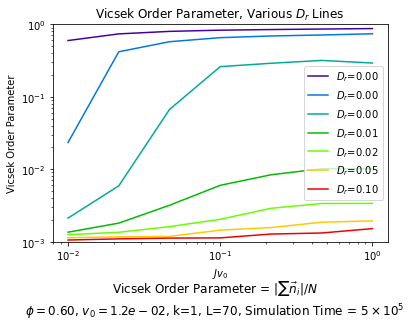

In [57]:
fig, ax = plt.subplots()
colors=plt.cm.nipy_spectral(np.linspace(0,1,len(Dr_vals)+2))
for Dr_index, Dr_val in enumerate(Dr_vals):
    ax.plot(Jv_vals, vicsek_vals[Dr_index],c=colors[Dr_index+1], label=r'$D_r$=%.2f'%(Dr_val))
    
ax.set_ylim(0,1)
plt.title(r'Vicsek Order Parameter, Various $D_r$ Lines')
plt.xlabel(r'$Jv_0$')
plt.ylabel('Vicsek Order Parameter')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()

fig.text(.5, -0.05, r"Vicsek Order Parameter = $\left| \sum \vec{n}_i \right| / N$", ha='center', fontsize=12)
fig.text(.5, -0.13, simulation_desc, ha='center', fontsize=12)
base_filename = os.path.join(save_dir, 'phase_diagrams')
save_fig_pdf(base_filename, "phi=%.4f_and_v0=%.4f_Dr_lines.pdf"%(phi, v0))
plt.show()